# 重新实现之前的线性热模型
应该只需要读取第一次实验的数据，这里主要想规范一下之前的写法

In [1]:
import pandas as pd
import numpy as np
import os
from keys import *
import math

from tqdm import tqdm
from loader import Loader
from thermal_model.data import *
from thermal_model.configs import *
from thermal_model.figure_plotter import *
from utils_thermal_model_raw_process import *
import matplotlib.pyplot as plt
from plotter import Plotter
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lars
from sklearn.ensemble import RandomForestRegressor
from thermal_model.thermal_model import fit_random_forest, model_estimator,fit_LARS
import pickle
import math
from thermal_model.electrolyzer import Electrolyzer
from thermal_model.original_thermal_model_and_plotter_0117 import current_TlyeIn_liftcycle_cost



# 读取数据并且缓存成单独pickle

In [ ]:
df_thermal_model_data_raw = ThermalModelData().load()

# 生成线性模型的输入项

In [ ]:
df_thermal_model_data_input = generate_model_input(df_thermal_model_data_raw)

In [ ]:
df_thermal_model_data_input.columns

# 生成模型（应该使用线性模型）

In [ ]:
model_random_forest,model_input,model_target = fit_random_forest(df_thermal_model_data_input,6)

In [ ]:
( model_predict, error) = model_estimator(
    model_random_forest,model_input,model_target
)

In [ ]:
Thermal_model_regression_scatter(
    model_target = model_target,
    model_predict = model_predict,
    title_model="随机森林",
).save()

In [ ]:
Thermal_model_regression_error_histplot(
    model_target=model_target,
    error=error,
    title_model="随机森林"
).save()

In [ ]:
Thermal_model_regression_cumulative_error_plot(
    model_target=model_target,
    model_predict=model_predict
).save()

In [ ]:
model_lars,model_input,model_target = fit_LARS(df_thermal_model_data_input)

In [ ]:
( model_predict, error) = model_estimator(
    model_lars,model_input,model_target
)

In [ ]:
Thermal_model_regression_scatter(
    model_target = model_target,
    model_predict = model_predict,
    title_model="LARS",
).save()

In [ ]:
Thermal_model_regression_error_histplot(
    model_target=model_target,
    error=error,
    title_model="LARS"
).save()

In [ ]:
Thermal_model_regression_cumulative_error_plot(
    model_target=model_target,
    model_predict=model_predict,
    title_model='LARS'
).save()

# 测试模型功能

28.422528288090636 620 59
the consumed time is 1.1325230598449707
the consumed time per point is 0.00019359368544358475


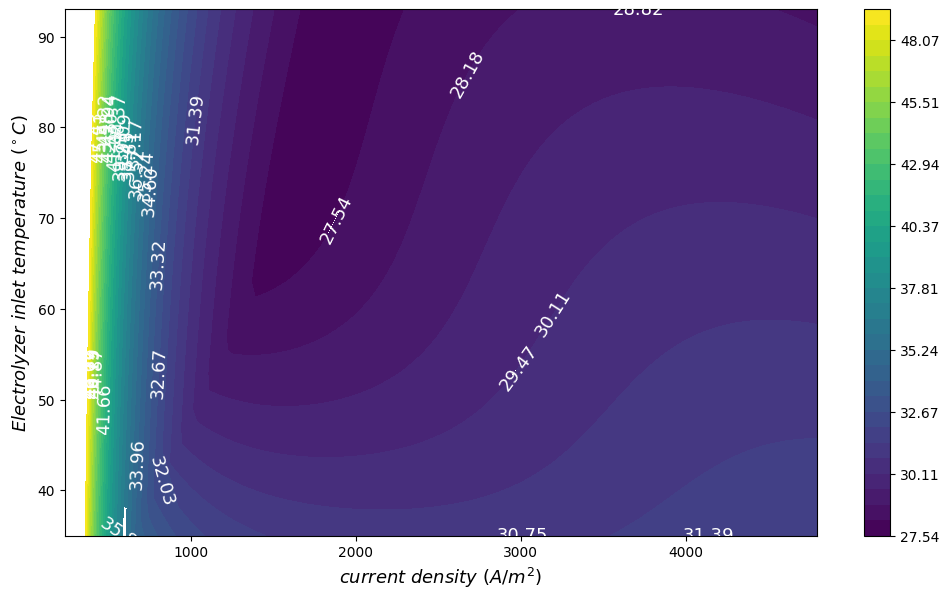

In [2]:
current_TlyeIn_liftcycle_cost()

In [ ]:
class Model_life_cycle_hydrogen_cost(QuadroPlotter):
    def __init__(
        self, 
        label="Thermal model", 
        title="不同工况下电解槽全生命周期制氢成本", 
        num_subplot=4, 
        title_plot=False
    ) -> None:
        super().__init__(label, title, num_subplot, title_plot)
        # 这里应该包含两个大类，一个是30万一个是60万成本
        self.electrolyzer = Electrolyzer()
    
    def plot_1(self):
        lye_temperature_range = range(
            OperatingRange.Contour.Lye_temperature.left,
            OperatingRange.Contour.Lye_temperature.right,
            OperatingRange.Contour.Lye_temperature.step
        )
        current_range = range(
            OperatingRange.Contour.Current.left,
            OperatingRange.Contour.Current.right,
            OperatingRange.Contour.Current.step
        )
        ambient_temperature = OperatingCondition.Default.ambient_temperature
        lye_flow = OperatingCondition.Default.lye_flow
        cost_matrix = np.ones(
            (
                len(lye_temperature_range),
                len(current_range)
            )
        ) # 电解槽全生命周期制氢成本


    def plot_2(self):
        1
    
    def plot_3(self):
        1

    def plot_4(self):
        1

In [3]:
cooling_efficiency = LifeCycle.cooling_efficiency
heating_efficiency = LifeCycle.heating_efficiency
current = 620
lye_temperature = 59
ambient_temperature = OperatingCondition.Default.ambient_temperature
lye_flow = 1
electricity_price = 0.4
electrolyzer_price = 300000

In [5]:
Electrolyzer().hydrogen_cost_lifecycle(
    current=current,
    ambient_temperature=ambient_temperature,
    lye_temperature=lye_temperature,
    lye_flow=lye_flow,
    electricity_price=0.4,
    electrolyzer_price=300000
)

28.220758760645733

# 依次生成论文图片

In [ ]:
Initial_delta_temp_histplot().save()

In [ ]:
Initial_delta_temp_pairplot().save()

In [ ]:
Model_input_data_pairplot().save()

In [ ]:
Model_default_polarization_curve().save()

In [ ]:
Thermal_model_regression_scatter().save()

In [ ]:
Thermal_model_regression_error_histplot().save()

In [ ]:
Thermal_model_regression_cumulative_error_plot().save()

In [ ]:
Model_polarization_different_lye_temperature().save()

In [ ]:
Model_faraday_efficiency_different_lye_temperature().save()

In [ ]:
Model_output_temperature_different_lye_temperature().save()

In [ ]:
Model_output_input_temperature_delta().save()

In [ ]:
Model_output_temperature_different_lye_temperature().save()

In [ ]:
Model_output_input_temperature_delta().save()

In [ ]:
Model_cooling_power_requirement().save()

In [ ]:
Model_efficiency_hydrogen_cost().save()